In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


# Read MNIST data:
There are many [ways](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python) you can read the MNIST data. Here is a [way](https://stackoverflow.com/a/62781370) to read all the information.

Train data (X) size: (60000, 28, 28), and labels (Y) size: (60000,)
Test data (X) size: (10000, 28, 28), and labels (Y) size: (10000,)


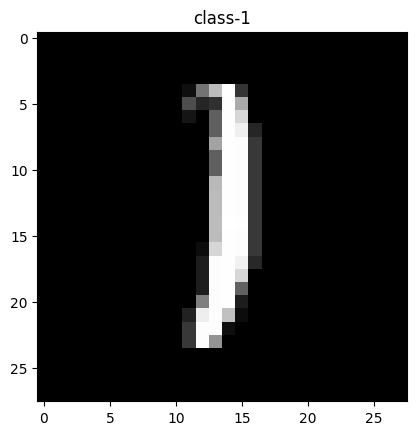

Train image 18647-th sample 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  15 115 188 255  52   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  77  38  49 254 170   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  21   0  95 254 215   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  95 254 240  38   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  

In [2]:
def read_images(filename):
    """Read MNIST images"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        
    return images

def read_labels(filename):
    """Read MNIST labels"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
    return labels


dataset_path = '/home/sysadm/Desktop/ML_Assignment'     # Change your data path

train_image_filename = ''.join([dataset_path, 'train-images-idx3-ubyte.gz'])
train_label_filename = ''.join([dataset_path, 'train-labels-idx1-ubyte.gz'])

test_image_filename = ''.join([dataset_path, 't10k-images-idx3-ubyte.gz'])
test_label_filename = ''.join([dataset_path, 't10k-labels-idx1-ubyte.gz'])

train_images = read_images('train-images-idx3-ubyte.gz')
train_labels = read_labels('train-labels-idx1-ubyte.gz')
print('Train data (X) size: {}, and labels (Y) size: {}' .format(train_images.shape, train_labels.shape))

test_images = read_images('t10k-images-idx3-ubyte.gz')
test_labels = read_labels('t10k-labels-idx1-ubyte.gz')
print('Test data (X) size: {}, and labels (Y) size: {}' .format(test_images.shape, test_labels.shape))

rand_ids = np.random.choice(train_images.shape[0])
plt.imshow(train_images[rand_ids, :, :], cmap='gray')
plt.title('class-'+str(train_labels[rand_ids]))
plt.show()

print('Train image {}-th sample ' .format(rand_ids))
print(train_images[rand_ids, :, :])



# Extract 20% data from the training data as a validation set. <font color='red'>Please do not use some standard function from scikit-learn or others!</font>

In [7]:
# Define the size of the validation set (e.g., 20%)
validation_ratio = 0.2

# Shuffle the indices of the training data
num_samples = len(train_images)
indices = np.random.permutation(num_samples)

# Calculate the number of samples for the validation set
num_validation_samples = int(validation_ratio * num_samples)

# Split the training data into training and validation sets
validation_indices = indices[:num_validation_samples]
training_indices = indices[num_validation_samples:]

# Extract the validation set and update the training set
image_validation = train_images[validation_indices].astype(np.float32)
label_validation = train_labels[validation_indices]

train_images_new = train_images[training_indices].astype(np.float32)
train_labels_new = train_labels[training_indices]

print("Image training set size:", len(train_images_new))
print("Image validation set size:", len(image_validation))
print("Label training set size:", len(train_labels_new))
print("Label validation set size:", len(label_validation))


Image training set size: 48000
Image validation set size: 12000
Label training set size: 48000
Label validation set size: 12000


# Implement k-NN classification rule/algorithm, we have discussed in our class. <font color='red'>Please do not use some standard function from scikit-learn or others!</font>

In [4]:

def knn_predict(x_train, y_train, x_test, k, p):
    if p == 1:
        distances = np.sum(np.abs(x_train - x_test), axis=(1, 2))    # manhattan_distance
    elif p == 2:
        distances = np.sqrt(np.sum((x_train - x_test)**2, axis=(1, 2)))  # euclidean_distance
    elif p == 'inf':
        distances = np.max(np.abs(x_train - x_test), axis=(1, 2))    # chebyshev_distance

    nearest_indices = np.argsort(distances)[:k]
    labels = y_train[nearest_indices]
    prediction = np.argmax(np.bincount(labels))
    return prediction

# Define the range of p and k values to test
p_values = [1, 2, 'inf']
k_values = [25, 23, 21, 19, 17, 15 ,13, 11, 9, 7, 5, 3, 1]

# Initialize lists to store accuracy/error rates
accuracies = []
errors = []

for p in p_values:
    for k in k_values:
        correct = 0
        for i in range(len(image_validation)):
            prediction = knn_predict(train_images_new, train_labels_new, image_validation[i], k, p)
            if prediction == label_validation[i]:
                correct += 1
        accuracy = correct / len(image_validation)
        accuracies.append(accuracy)
        errors.append(1 - accuracy)

# Reshape the results for plotting
accuracies = np.array(accuracies).reshape(len(p_values), len(k_values))
errors = np.array(errors).reshape(len(p_values), len(k_values))
print(accuracies)
print(errors)


[[0.855  0.8625 0.865  0.87   0.87   0.875  0.87   0.87   0.875  0.88
  0.8925 0.8925 0.9025]
 [0.8825 0.885  0.8775 0.8825 0.8875 0.8875 0.89   0.895  0.8975 0.8875
  0.895  0.905  0.905 ]
 [0.585  0.585  0.5725 0.585  0.6    0.5975 0.575  0.6025 0.615  0.615
  0.6075 0.61   0.6425]]
[[0.145  0.1375 0.135  0.13   0.13   0.125  0.13   0.13   0.125  0.12
  0.1075 0.1075 0.0975]
 [0.1175 0.115  0.1225 0.1175 0.1125 0.1125 0.11   0.105  0.1025 0.1125
  0.105  0.095  0.095 ]
 [0.415  0.415  0.4275 0.415  0.4    0.4025 0.425  0.3975 0.385  0.385
  0.3925 0.39   0.3575]]


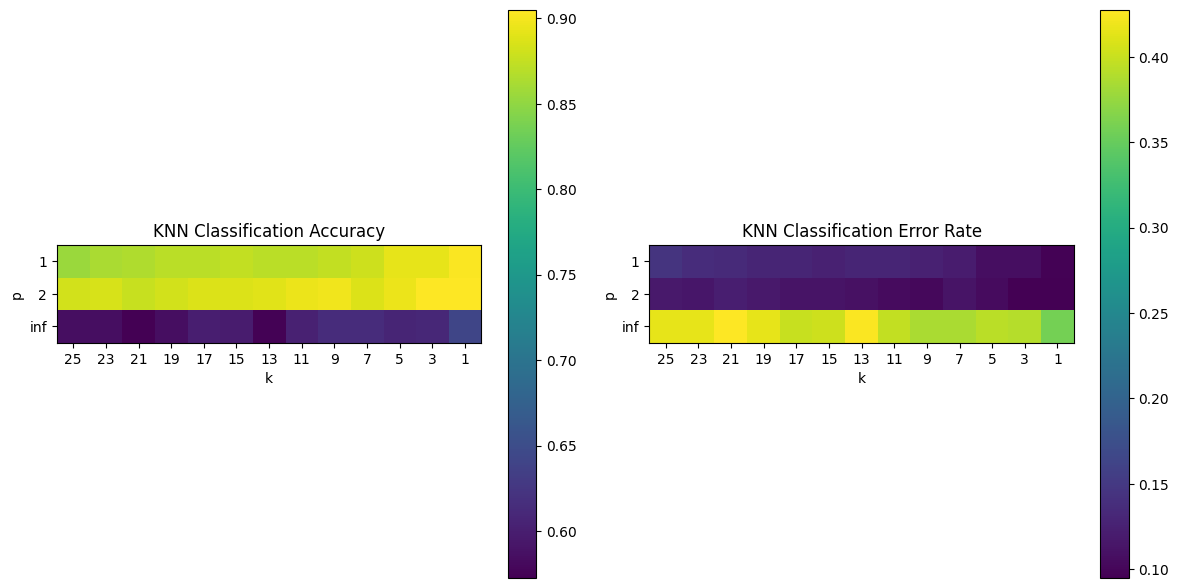

In [5]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(k_values)), k_values)
plt.yticks(range(len(p_values)), p_values)
plt.xlabel('k')
plt.ylabel('p')
plt.title('KNN Classification Accuracy')

plt.subplot(1, 2, 2)
plt.imshow(errors, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(k_values)), k_values)
plt.yticks(range(len(p_values)), p_values)
plt.xlabel('k')
plt.ylabel('p')
plt.title('KNN Classification Error Rate')

plt.tight_layout()
plt.show()